# Unsupervised Analysis of Polycrystalline Graphene 

In this notebook, we demonstrate unsupervised strain analysis using polycrystalline graphene as an example. You will see that there is no sample specific parameters nor any parameters specific to graphene. Hence, this notebook can be modified for analysis of other samples with very little effort.

The analysis assumes that there are enough unperturbed lattice for use as reference.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from psm.cluster import Cluster
from psm.segments import Segments
from psm.build import lattice_segment
from psm import plotutils

In [3]:
np.random.seed(13)

## Sample Structure
The sample points are imported and we build the geometric graph.

(-2.442212324568, 52.486549836407995, -2.49008957172, 52.46567162532)

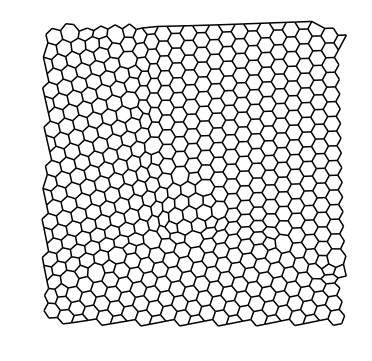

In [127]:
points = np.load('data/poly_graphene.npy')

segments = Segments(points)
segments.build_graph(1.2)

fig,axes=plt.subplots(figsize=(6,6))
segments.show_edges(ax=axes);

axes.axis('off')

#plt.savefig('graphene.pdf')

We use clockwise graph traversals to extracts segments of 10 points from the larger sample. A sample of 10 of these sub-structures are shown.

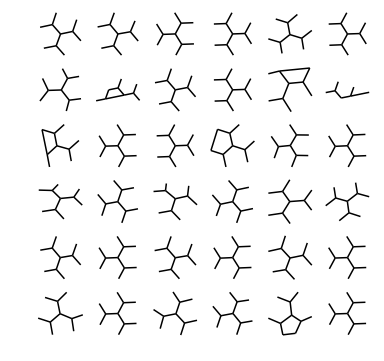

In [128]:
fig,axes=plt.subplots(6,6,figsize=(6,6))

segments.traversals(max_depth=3)
segments.show(36, nrows=6, axes=axes,sample=True);

for ax in axes:
    for ax in ax:
        ax.axis('off')

#plt.savefig('segments.pdf')

## Template structure
The clustering algorithm requires calculation of the pairwise RMSD between all segments, the time-complexity is thus $\mathcal{O}(N^2)$ with the number of segments $N$. To speed up the 


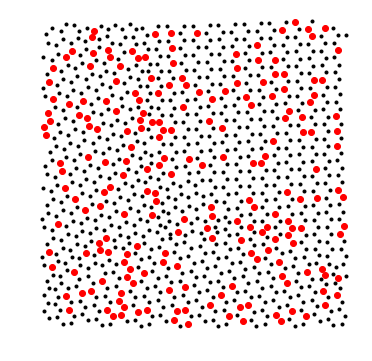

In [129]:
sample = segments.sample(.2)

fig,ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(segments.fronts[:,0], segments.fronts[:,1], 'k.')
ax.plot(sample.fronts[:,0], sample.fronts[:,1], 'ro')
ax.axis('equal')
ax.axis('off');

In [131]:
clusterer = Cluster(eps=.05, min_samples=10)
labels = clusterer.fit(sample)

 [||||||||||||||||||||] 20910/20910 registrations


In [65]:
clusterer = Cluster(eps=.1, min_samples=10)
labels_01 = clusterer.fit(sample)

clusterer = Cluster(eps=.075, min_samples=10)
labels_0075 = clusterer.fit(sample)

clusterer = Cluster(eps=.05, min_samples=10)
labels_005 = clusterer.fit(sample)

clusterer = Cluster(eps=.025, min_samples=10)
labels_0025 = clusterer.fit(sample)

 [||||||||||||||||||||] 528906/528906 registrations


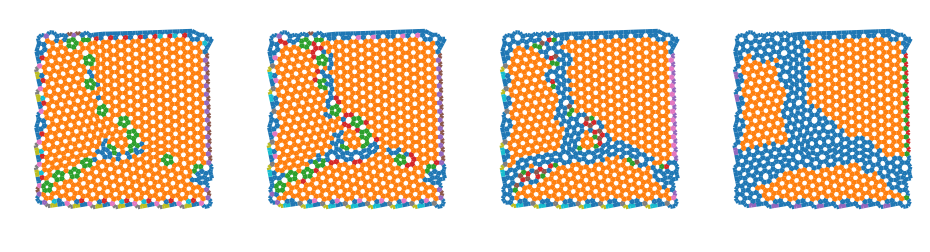

In [97]:
#for i,l in enumerate([labels_01,labels_0075,labels_005,labels_0025]):
fig, axes = plt.subplots(1, 4, figsize=(16,4))
for i,(l,ax) in enumerate(zip([labels_01,labels_0075,labels_005,labels_0025],axes)):
    plotutils.edge_plot(sample, ax=ax, c=l, color_mode='ends', cmap='tab10', vmin=-1, vmax=8, linewidth=4)
    ax.axis('off')
#plt.savefig('unsupervised.pdf')



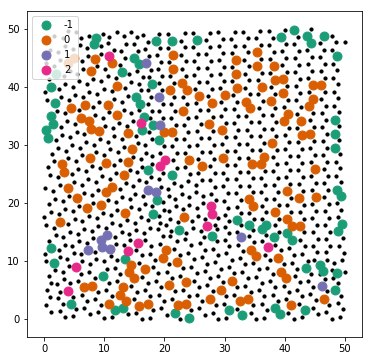

In [132]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(segments.fronts[:,0], segments.fronts[:,1], c='k', s=10)

for label,color in zip(np.unique(labels), plt.cm.Dark2.colors):
    points = sample.fronts[label == labels]
    ax.scatter(points[:,0], points[:,1], c=color, s=80, label=label)

ax.legend()

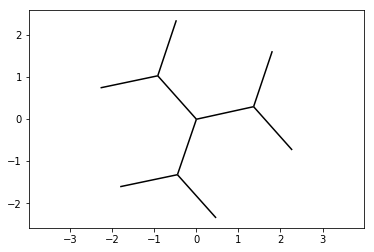

In [133]:
templates = clusterer.principal_structures(1)

templates.show();

## Pairing

In [134]:
rmsd = segments.register(templates, transform='similarity', pivot='front')

 [||||||||||||||||||||] 1029/1029 registrations


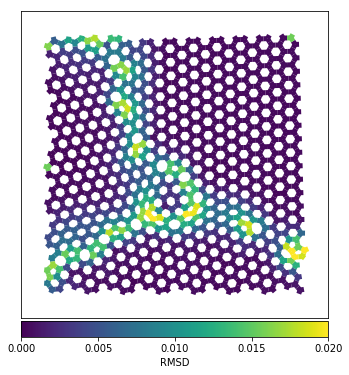

In [135]:
_, best_rmsd = segments.best_matches()

fig, ax = plt.subplots(1, 1, figsize=(6,6))

plotutils.edge_plot(segments, ax=ax, c=best_rmsd, color_mode='ends', vmin=0, vmax=.08, linewidth=5)
plotutils.add_colorbar(ax, label='RMSD', cmap='viridis', vmin=0, vmax=.02)

ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([]);

## Strain

In [136]:
strain, rotation = segments.calc_strain(adjust_zero='median', rmsd_max=.1)

rotation[np.isnan(rotation)==False] = rotation[np.isnan(rotation)==False] % (np.pi/3)

planar = np.trace(strain, axis1=1, axis2=2) / 2

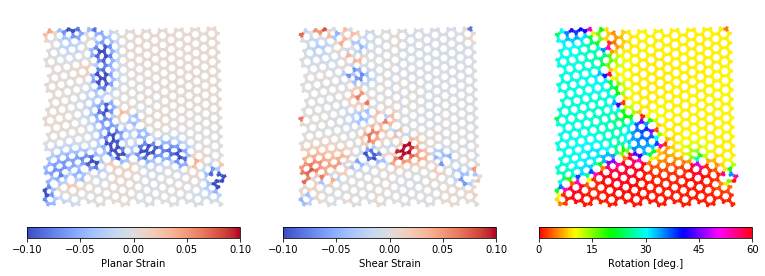

In [140]:
fig,axes = plt.subplots(1,3,figsize=(13,6))

plotutils.edge_plot(segments, ax=axes[0], c=planar, color_mode='ends', cmap='coolwarm', vmin=-.1, vmax=.1, linewidth=3)
plotutils.add_colorbar(axes[0], label='Planar Strain', cmap='coolwarm', vmin=-.1, vmax=.1)

plotutils.edge_plot(segments, ax=axes[1], c=strain[:,0,1], color_mode='ends', cmap='coolwarm', vmin=-.1, vmax=.1, linewidth=3)
plotutils.add_colorbar(axes[1], label='Shear Strain', cmap='coolwarm', vmin=-.1, vmax=.1)

plotutils.edge_plot(segments, ax=axes[2], c=rotation / np.pi * 180, color_mode='ends', cmap='hsv', 
                    vmin=0, vmax=60, linewidth=3)
plotutils.add_colorbar(axes[2], label='Rotation [deg.]', cmap='hsv', vmin=-0, vmax=60)

for ax in axes:
    ax.axis('equal'); ax.axis('off')
    
plt.savefig('graphene_strain.pdf')